In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing
import sklearn.neural_network

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)

In [3]:
import theano
import theano.tensor as T

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
def sgd(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append((p, p - lr * g))
    return updates

In [5]:
def sgd_momentum(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):  #no bias correction
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc= beta*v + (1-beta)*g
        updates.append((v,vc))
        updates.append((p, p - lr * vc))
    return updates

In [6]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [7]:
def adam(cost, params, lr=0.001, epsilon=1e-6):  #no bias correction, T.sqrt if **0.5 not work
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        m=theano.shared(p.get_value()* 0.)
        v=theano.shared(p.get_value()* 0.)
        mc = beta1*m + (1-beta1)*grad(x)
        vc = beta2*v + (1-beta2)*grad(x)**2
        updates.append((m,mc))
        updates.append((v,vc))
        updates.append((p, p - lr * mc/(epsilon+vc**0.5)))
    return updates

In [8]:
def RMSprop(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc = beta*v + (1-beta)*g**2
        updates.append((v,vc))
        updates.append((p, p - lr * g/(epsilon+vc**(0.5))))
    return updates

In [9]:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='latin-1')
f.close()

In [10]:
train_set[0][train_set[0]>=0.5]=1
train_set[0][train_set[0]<0.5]=0

In [11]:
valid_set[0][valid_set[0]>=0.5]=1
valid_set[0][valid_set[0]<0.5]=0

In [12]:
test_set[0][test_set[0]>=0.5]=1
test_set[0][test_set[0]<0.5]=0

In [13]:
x_train=theano.function([], T.concatenate([train_set[0], valid_set[0]]))()

In [14]:
x_test = theano.function([], theano.shared(test_set[0]))()

In [25]:
n_hidden = 100 # the size of hidden layers in MLP
n_latent = 2 # the dimension of z
n_input = x_train.shape[1] # the dimension of x's feature space
batch_size = 100
n_epochs = 10000

In [26]:
def init_w(shape):
    x = np.random.randn(*shape)
    float_x = np.asarray(x * 0.01, dtype=theano.config.floatX)
    return theano.shared(float_x)

In [27]:
# Parameters
# Gaussian MLP weights and biases (encoder)
#initialize \phi 

b3 = init_w((n_hidden, ))
b2 = init_w((n_latent, ))
b1 = init_w((n_latent, ))


W3 = init_w((n_input, n_hidden))
W2 = init_w((n_hidden, n_latent))
W1 = init_w((n_hidden, n_latent))


In [28]:
# Gaussian Encoder
x = T.matrix("x")
h_encoder = T.tanh(T.dot(x, W3) + b3)
mu = T.dot(h_encoder, W1) + b1
log_sig2 = T.dot(h_encoder, W2) + b2
# This expression is simple (not an expectation) because we're using normal priors and posteriors
DKL = (1.0 + log_sig2 - mu**2 - T.exp(log_sig2)).sum(axis = 1)/2.0

In [29]:
# Bernoulli MLP weights and biases (decoder)
bernoulli_b1 = init_w((n_hidden, ))
bernoulli_b2 = init_w((n_input, ))

bernoulli_W1 = init_w((n_latent, n_hidden))
bernoulli_W2 = init_w((n_hidden, n_input))

In [30]:
# Bernoulli Decoder
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, bernoulli_W1) + bernoulli_b1)
y = T.nnet.sigmoid(T.dot(h_decoder, bernoulli_W2) + bernoulli_b2)
log_likelihood = -T.nnet.binary_crossentropy(y, x).sum(axis = 1)


In [31]:
# Only the weight matrices W will be regularized (weight decay)
W = [W3, W1, W2, bernoulli_W1, bernoulli_W2]
b = [b3, b1, b2, bernoulli_b1, bernoulli_b2]
params = W + b

In [32]:
# Our lb and cost
lower_bound = (DKL + log_likelihood).mean()
cost = -lower_bound

In [33]:
updates = adagrad(cost, params, lr=0.02)

In [34]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)

In [35]:
'''adagrad optimizer with latent variable z dimension of 2'''
training = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training.append(train_cost)

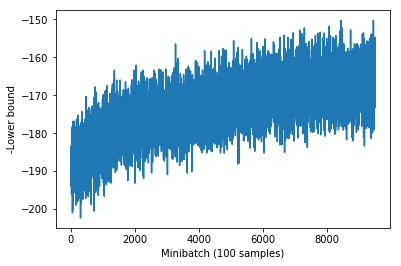

In [37]:
'''plot lower bound of adagrad 2D z'''
lb=[-i for i in training]
plt.ylabel("-Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(lb[500:])
plt.show()

In [84]:
updates = adagrad(cost, params, lr=0.02)

In [85]:
train_model_likelihood = theano.function(inputs=[x, std_normal], 
                              outputs=log_likelihood.mean(), 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)

In [86]:
training_likelihood_z10 = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]
    
    likelihood = train_model_likelihood(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_likelihood_z10.append(likelihood)

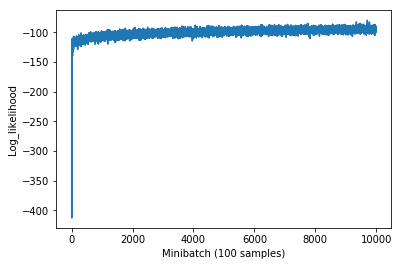

In [87]:
'''plot loglikelihood of adagrad 2D z'''
plt.ylabel("Log_likelihood")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(training_likelihood_z10)
plt.show()

In [ ]:
'''Repeat with experiments of z dimension of 3,5,10'''

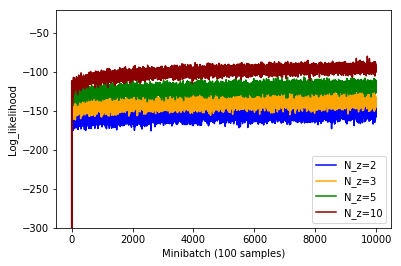

In [114]:
plt.ylabel("Log_likelihood")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(training_likelihood_z2,'blue',label='N_z=2')
plt.plot(training_likelihood_z3,'orange',label='N_z=3')
plt.plot(training_likelihood_z5,'green',label='N_z=5')
plt.plot(training_likelihood_z10,'darkred',label='N_z=10')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.ylim(-300, )
plt.savefig('train_log_likelihood.pdf', dpi=300)
plt.show()

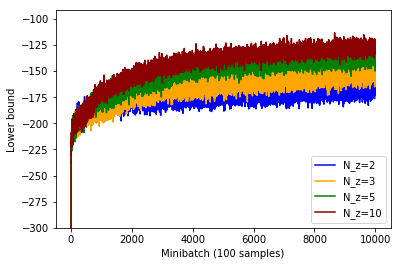

In [115]:
plt.ylabel("Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(-np.array(training_z2),'blue',label='N_z=2')
plt.plot(-np.array(training_z3),'orange',label='N_z=3')
plt.plot(-np.array(training_z5),'green', label='N_z=5')
plt.plot(-np.array(training_z10),'darkred',label='N_z=10')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.ylim(-300, )
plt.savefig('train_lower_bound.pdf', dpi=300)
plt.show()

In [ ]:
'''Test set reconstruction with adagrad and Nz=2 learned model'''

In [40]:
# Extract estimated parameters (W, b)
est_W3 = updates[1][0].get_value()
est_W1 = updates[3][0].get_value()
est_W2 = updates[5][0].get_value()
est_b_W1 = updates[7][0].get_value()
est_b_W2 = updates[9][0].get_value()

est_b3 = updates[11][0].get_value()
est_b1 = updates[13][0].get_value()
est_b2 = updates[15][0].get_value()
est_b_b1 = updates[17][0].get_value()
est_b_b2 = updates[19][0].get_value()

In [41]:
import numba
from numba import jit

@jit
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [42]:
'''Gaussian Encoder'''
est_h_encoder = np.tanh(np.dot(x_test, est_W3) + est_b3)
phi_mu = np.dot(est_h_encoder, est_W1) + est_b1
phi_log_sig2 = np.dot(est_h_encoder, est_W2) + est_b2

In [43]:
'''sample z'''
a, b =phi_log_sig2.shape 
z_ = phi_mu + np.sqrt(np.exp(phi_log_sig2))*np.random.randn(a, b)

In [44]:
'''Bernoulli Decoder'''
est_h_decoder = np.tanh(np.dot(z_, est_b_W1) + est_b_b1)
c = np.dot(est_h_decoder, est_b_W2)
y_ = sigmoid(c + est_b_b2)

In [45]:
'''Prediction'''
x_new = np.random.binomial(1,y_,[10000,784])

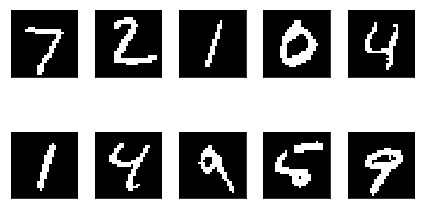

In [46]:
'''Visualize Original Test set'''
x_test = x_test.reshape([10000, 28, 28])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

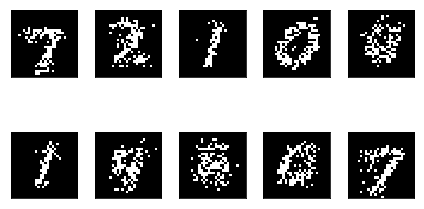

In [47]:
'''Visualize reconstructed test set'''
x_new = x_new.reshape([10000, 28, 28])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_new[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()